# PyTorch neural networks

In [5]:
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from utilities import generate_linear_dataset

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Generate a simple dataset.

In [88]:
x_train, y_train, x_val, y_val = generate_linear_dataset(
    n_samples_tot=200,
    n_samples_val=40,
    x_min=-3.,
    x_max=4.5,
    m_real=2.1,
    q_real=4.4,
    sigma_real=1.3,
)

# Add a batch dimension to the target values as well (needed by
# PyTorch's `Module` objects).
y_train = torch.unsqueeze(y_train, -1)
y_val = torch.unsqueeze(y_val, -1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([160, 1]),
 torch.Size([160, 1]),
 torch.Size([40, 1]),
 torch.Size([40, 1]))

Text(0, 0.5, 'y')

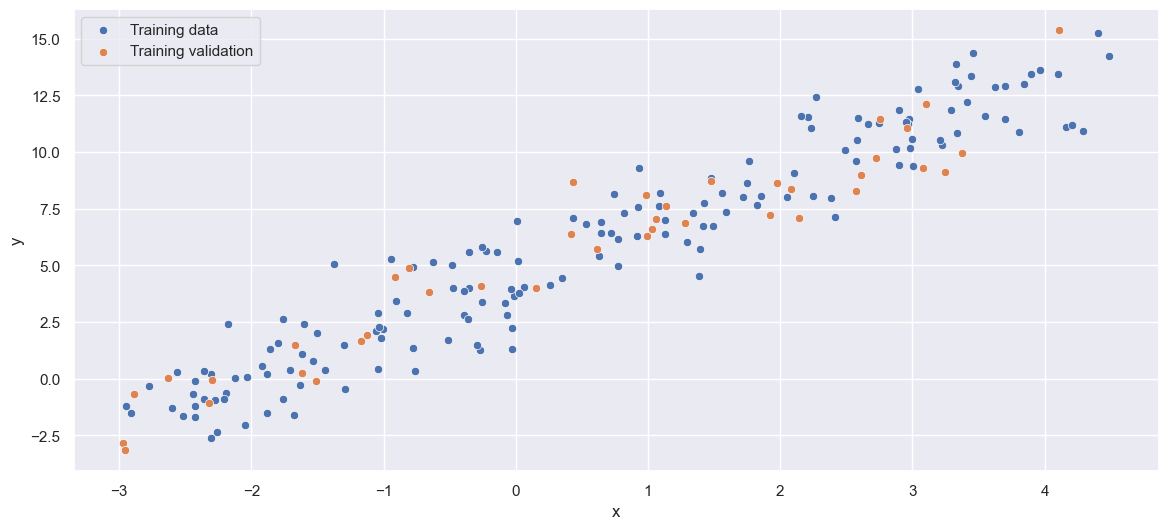

In [89]:
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

plt.xlabel('x')
plt.ylabel('y')

## A linear model as a NN

Define a neural network using PyTorch's `Module` objects (representing layers).

In [110]:
linear_model = nn.Linear(
    in_features=1,
    out_features=1
)

Make predictions over a range of input values with the untrained model.

**Batch dimension:** PyTorch interprets the first (left-most) dimension of the tensor passed as input to a `Module` object as the **batch dimension**. Therefore if we e.g. the input values are real numbers (1-dimensional), if we want to predict on a single sample we need to pass a tensor of shape `(1, 1)`, corrisponding to a single value in a batch of dimension 1. In terms of a module's initialization, this means that a `Module` object initialized with arguments `in_features=n_features` and `out_features=out_dim` will need to be called on input tensors of shape `(batch_dim, n_features)` and will output a tensor of shape `(batch_dim, out_dim)`.

Text(0, 0.5, 'y')

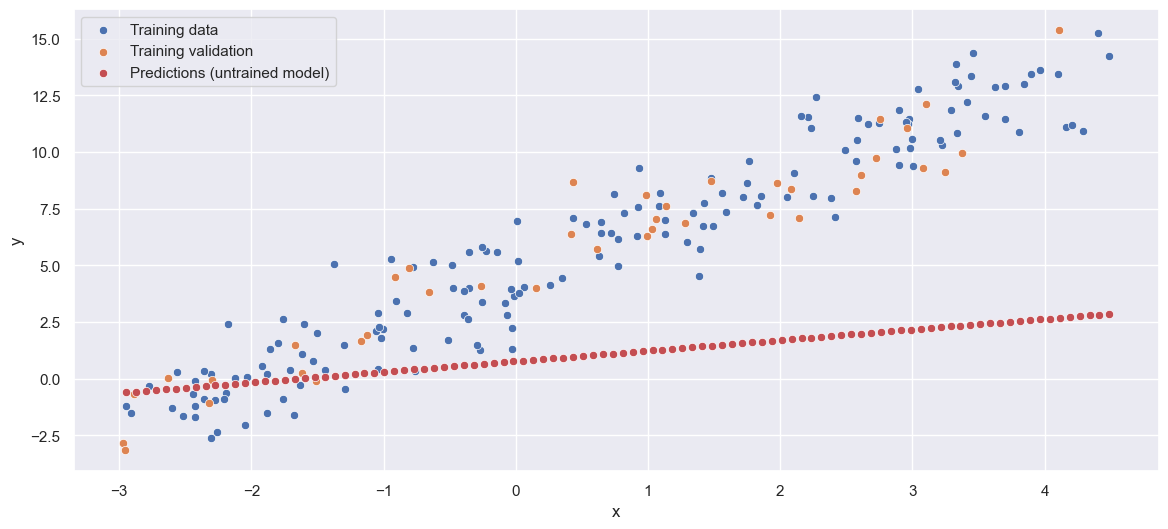

In [111]:
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

# Note: we turn off the computation of the gradient so autograd
#       doesn't trace the operation and we can freely use `y_pred`.
#       As an alternative, we could have detached the resulting
#       tensor from the computation graph with its `detach()` method.
with torch.no_grad():
    # Predictions are computed by calling the model (`Module` object
    # in this case) on the input (i.e. calling the `Module`'s `__call_`
    # method.
    y_pred = linear_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (untrained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')

Inspect the model's weights.

In [138]:
(
    linear_model.weight,
    linear_model.bias,
    list(linear_model.parameters()),  # Alternative: a generator returning all parameters.
    list(linear_model.named_parameters())  # Alternative: a generator returning all parameters with their names.
)

(Parameter containing:
 tensor([[2.1887]], requires_grad=True),
 Parameter containing:
 tensor([4.4024], requires_grad=True),
 [Parameter containing:
  tensor([[2.1887]], requires_grad=True),
  Parameter containing:
  tensor([4.4024], requires_grad=True)],
 [('weight',
   Parameter containing:
   tensor([[2.1887]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([4.4024], requires_grad=True))])

Model training.

In [113]:
from utilities import training_step_optimizer

In [115]:
# Losses are `Module` objects as well.
loss_fn = nn.MSELoss()

learning_rate = 1e-2

optimizer = torch.optim.SGD(
    # The `parameters()` method returns a generator
    # returning the parameters of the model.
    params=linear_model.parameters(),
    lr=learning_rate
)

training_history = {
    'loss': [],
    'val_loss': []
}

In [127]:
n_epochs = 100

for i in range(n_epochs):
    loss, val_loss = training_step_optimizer(
        training_data=(x_train, y_train),
        val_data=(x_val, y_val),
        model=linear_model,
        loss_fn=loss_fn,
        optimizer=optimizer
    )

    training_history['loss'].append(loss)
    training_history['val_loss'].append(val_loss)

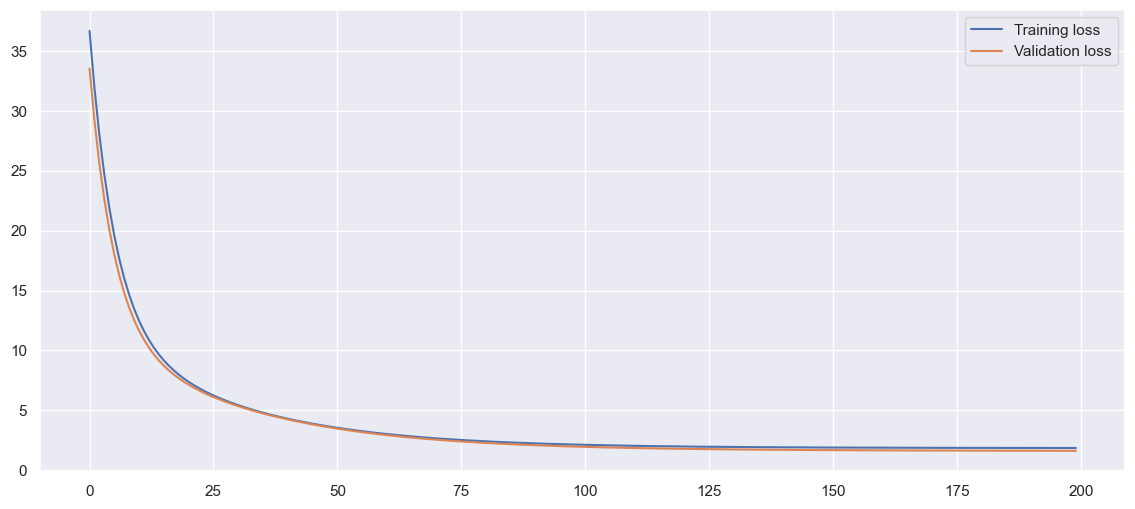

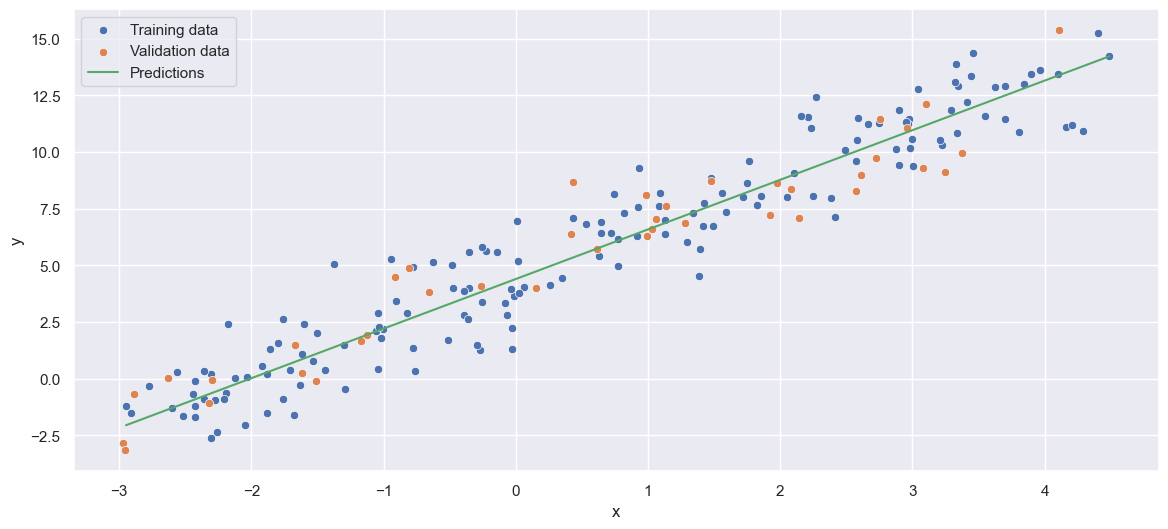

In [128]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history['loss'])).numpy(),
    y=training_history['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history['val_loss'])).numpy(),
    y=training_history['val_loss'],
    label='Validation loss',
)


# Data and predictions.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Validation data',
    color=sns.color_palette()[1]
)

x_pred = torch.linspace(x_train.min(), x_train.max(), 100)[:, None]

# Note: we need to `detach` the tensor (disconnect it from the
# computation graph for the gradient) to convert it to a
# NumPy array.
y_pred = linear_model(x_pred).detach()

sns.lineplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions',
    color=sns.color_palette()[2]
)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## A real NN (a `Sequential` model)

Define a simple neural network with one hidden layer and test it before training.

Stack of layers (`Module` objects) are built with PyTorch's `Sequential` container.

In [132]:
sequential_model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),  # Activation functions must be written explicitly.
    nn.Linear(10, 1)
)

sequential_model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [136]:
list(sequential_model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.8733],
          [-0.1827],
          [ 0.6953],
          [ 0.5385],
          [-0.9177],
          [-0.6231],
          [-0.9074],
          [ 0.9738],
          [-0.4484],
          [ 0.9177]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([ 0.5917, -0.1551, -0.3723,  0.4239, -0.1712, -0.3547,  0.5797,  0.2760,
          -0.0693,  0.8429], requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[-0.1155,  0.0428,  0.0465, -0.1914,  0.0872, -0.1183,  0.2024,  0.1983,
            0.1903,  0.2728]], requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([0.2016], requires_grad=True))]

Text(0, 0.5, 'y')

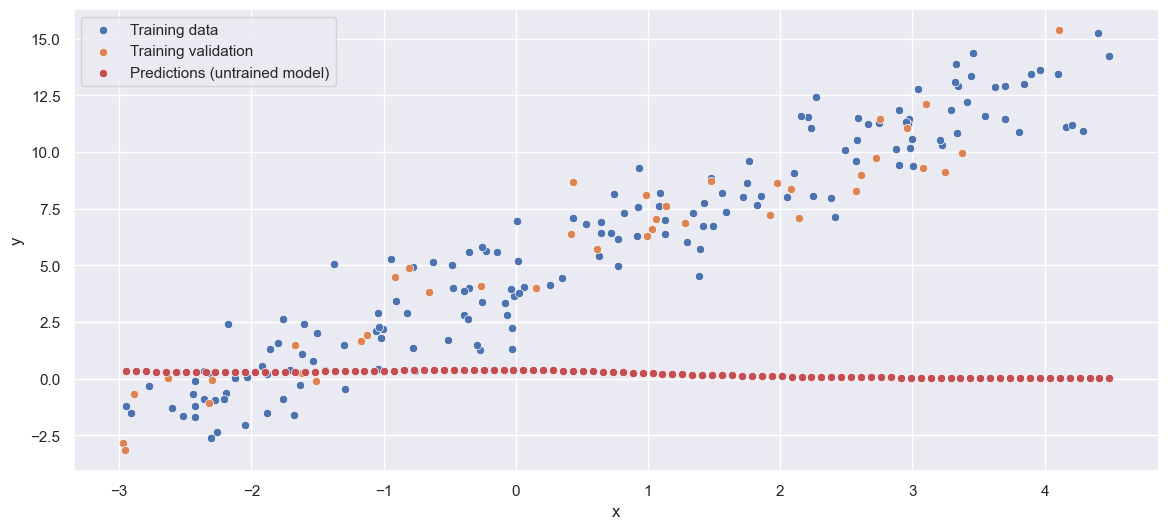

In [133]:
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

with torch.no_grad():
    y_pred = sequential_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (untrained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')

Accessing parameters by index: we can select a parameter from the list returned by the modules' `parameters()` or `named_parameters()` methods, which returns a PyTorch `Parameter` object whose `data` attribute contains the tensor associated with the parameter itself.

In [162]:
for p in sequential_model.named_parameters():
    print(f'{p[0]}: {p[1].data} (grad is null: {p[1].data.grad is None})')

0.weight: tensor([[ 0.8733],
        [-0.1827],
        [ 0.6953],
        [ 0.5385],
        [-0.9177],
        [-0.6231],
        [-0.9074],
        [ 0.9738],
        [-0.4484],
        [ 0.9177]]) (grad is null: True)
0.bias: tensor([ 0.5917, -0.1551, -0.3723,  0.4239, -0.1712, -0.3547,  0.5797,  0.2760,
        -0.0693,  0.8429]) (grad is null: True)
2.weight: tensor([[-0.1155,  0.0428,  0.0465, -0.1914,  0.0872, -0.1183,  0.2024,  0.1983,
          0.1903,  0.2728]]) (grad is null: True)
2.bias: tensor([0.2016]) (grad is null: True)


Model training.

In [165]:
loss_fn = nn.MSELoss()
learning_rate = 1e-2

optimizer = torch.optim.SGD(
    params=sequential_model.parameters(),
    lr=learning_rate
)

training_history_seq = {
    'loss': [],
    'val_loss': []
}

In [166]:
n_epochs = 300

for i in range(n_epochs):
    loss, val_loss = training_step_optimizer(
        training_data=(x_train, y_train),
        val_data=(x_val, y_val),
        model=sequential_model,
        loss_fn=loss_fn,
        optimizer=optimizer
    )

    training_history_seq['loss'].append(loss)
    training_history_seq['val_loss'].append(val_loss)

Text(0, 0.5, 'y')

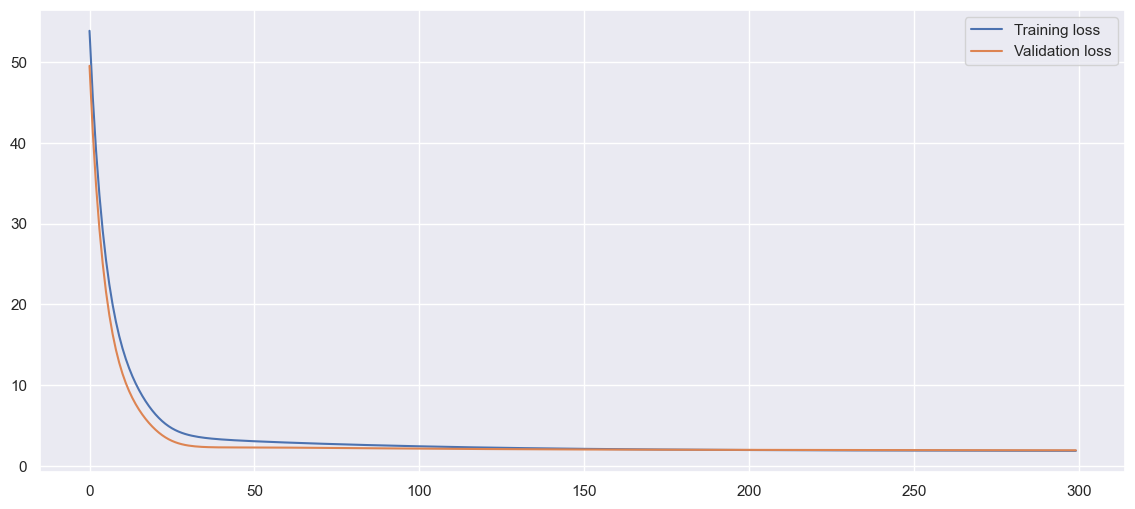

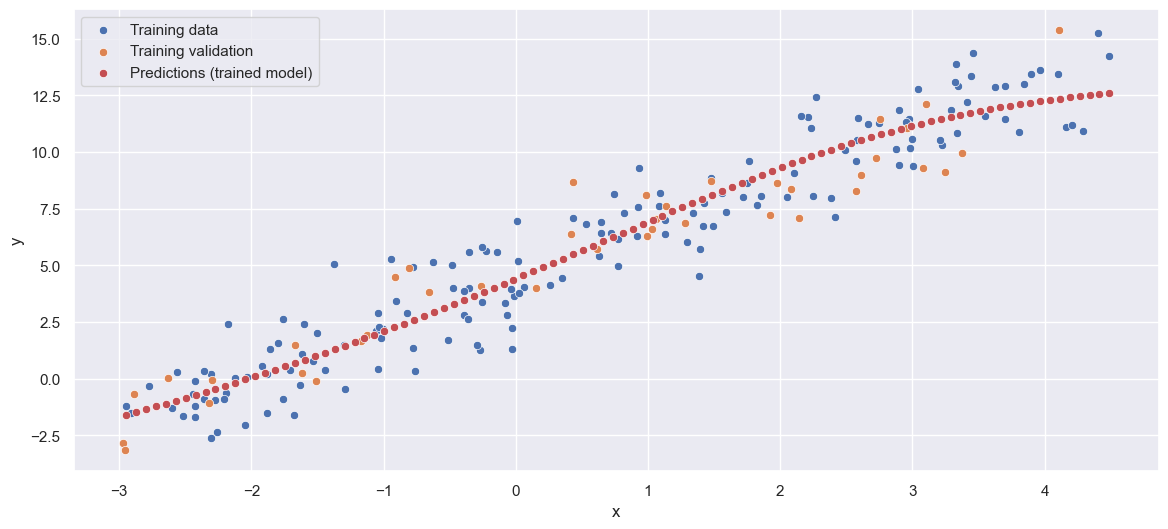

In [196]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history_seq['loss'])).numpy(),
    y=training_history_seq['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history_seq['val_loss'])).numpy(),
    y=training_history_seq['val_loss'],
    label='Validation loss',
)


# Data and predictions.
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

with torch.no_grad():
    y_pred = sequential_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (trained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')

## A NN as a `Module` subclass

In [171]:
from models import NNModel

In [203]:
nn_model = NNModel()

Text(0, 0.5, 'y')

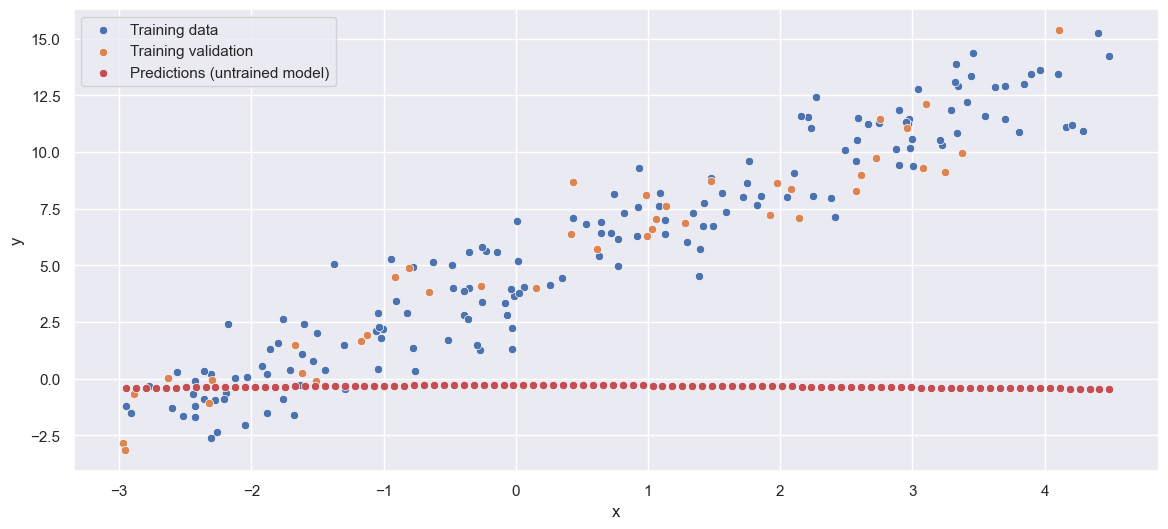

In [204]:
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

with torch.no_grad():
    y_pred = nn_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (untrained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')

In [205]:
loss_fn = nn.MSELoss()
learning_rate = 1e-2

optimizer = torch.optim.SGD(
    params=nn_model.parameters(),
    lr=learning_rate
)

training_history_nn = {
    'loss': [],
    'val_loss': []
}

In [206]:
n_epochs = 2000

for i in range(n_epochs):
    loss, val_loss = training_step_optimizer(
        training_data=(x_train, y_train),
        val_data=(x_val, y_val),
        model=nn_model,
        loss_fn=loss_fn,
        optimizer=optimizer
    )

    training_history_nn['loss'].append(loss)
    training_history_nn['val_loss'].append(val_loss)

Text(0, 0.5, 'y')

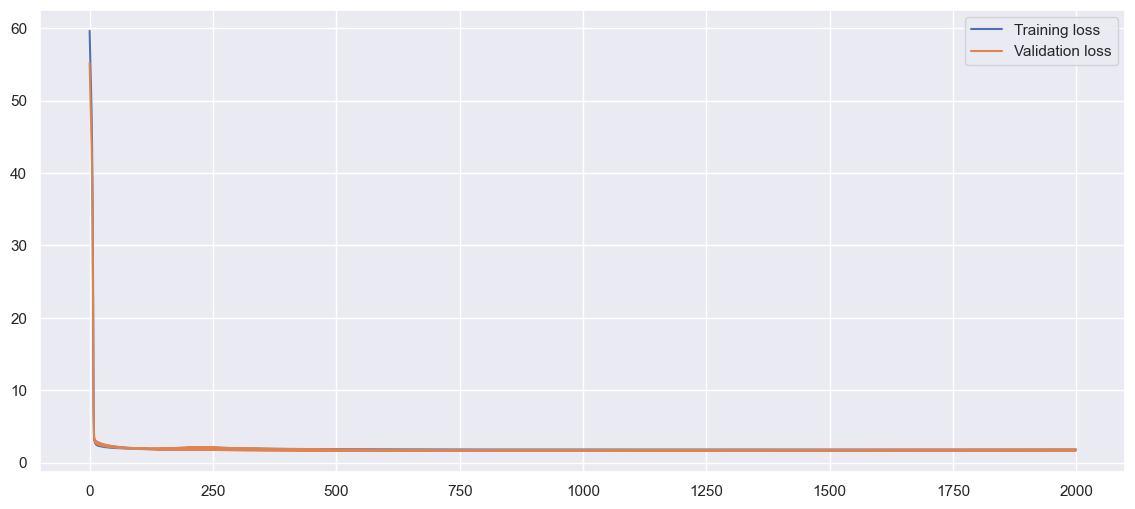

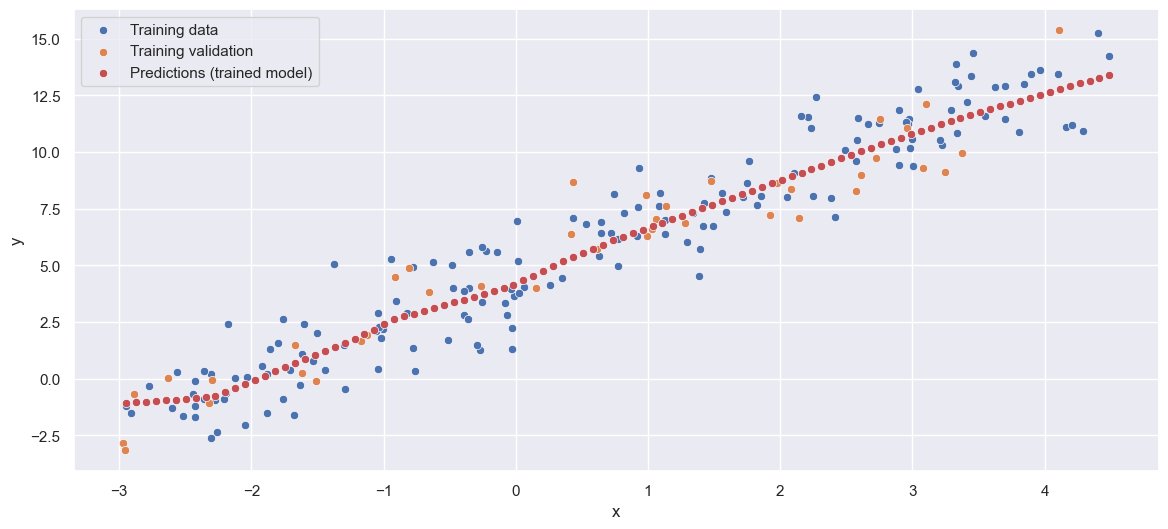

In [207]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history_nn['loss'])).numpy(),
    y=training_history_nn['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history_nn['val_loss'])).numpy(),
    y=training_history_nn['val_loss'],
    label='Validation loss',
)


# Data and predictions.
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

with torch.no_grad():
    y_pred = nn_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (trained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')

# An arbitrary feed-forward NN

In [208]:
from models import FFNN

Define the model.

In [218]:
ffnn_model = FFNN(dims=[1, 5, 10, 5, 1])

Train the model.

In [219]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(
    params=ffnn_model.parameters(),
    lr=1e-2
)

training_history_ffnn = {
    'loss': [],
    'val_loss': []
}

In [220]:
n_epochs = 2000

for i in range(n_epochs):
    loss, val_loss = training_step_optimizer(
        training_data=(x_train, y_train),
        val_data=(x_val, y_val),
        model=ffnn_model,
        loss_fn=loss_fn,
        optimizer=optimizer
    )

    training_history_ffnn['loss'].append(loss)
    training_history_ffnn['val_loss'].append(val_loss)

Text(0, 0.5, 'y')

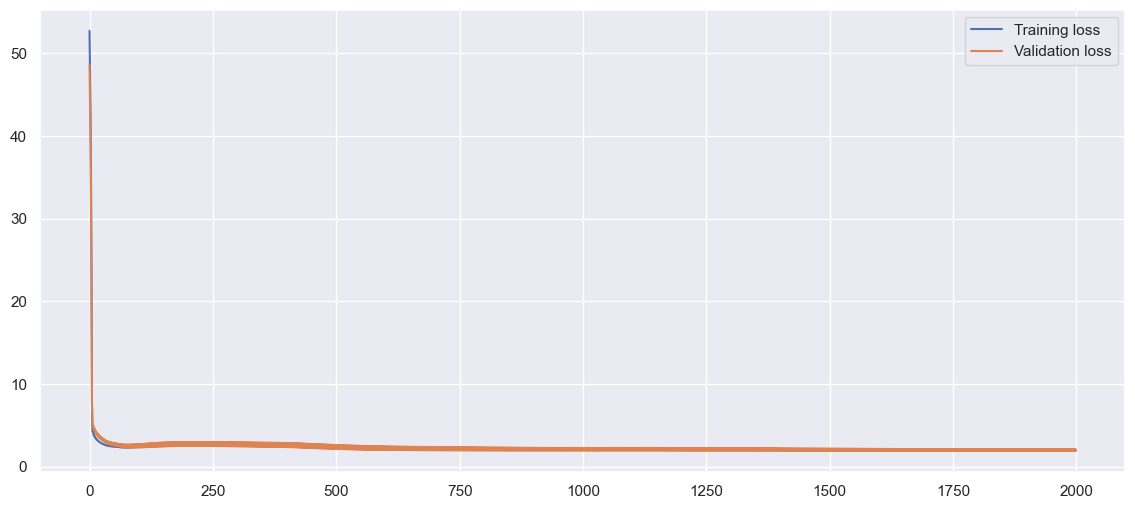

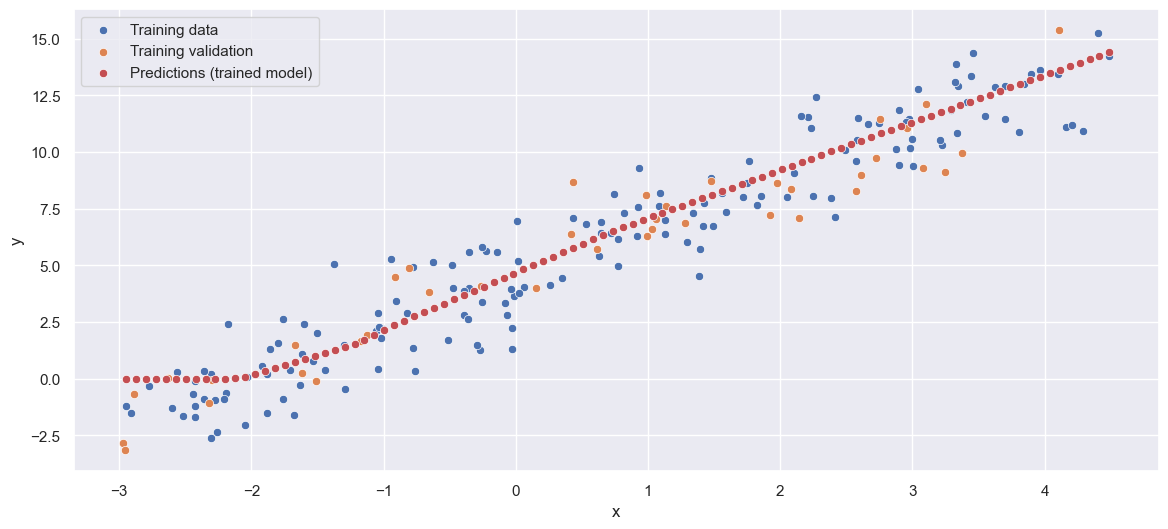

In [221]:
# Training history.
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=torch.arange(len(training_history_ffnn['loss'])).numpy(),
    y=training_history_ffnn['loss'],
    label='Training loss',
)

sns.lineplot(
    x=torch.arange(len(training_history_ffnn['val_loss'])).numpy(),
    y=training_history_ffnn['val_loss'],
    label='Validation loss',
)


# Data and predictions.
# Make predictions.
x_pred = torch.unsqueeze(
    torch.linspace(x_train[:, 0].min(), x_train[:, 0].max(), 100),
    -1
)

with torch.no_grad():
    y_pred = ffnn_model(x_pred)

# Plot.
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x_train[:, 0],
    y=y_train[:, 0],
    label='Training data',
    color=sns.color_palette()[0]
)

sns.scatterplot(
    x=x_val[:, 0],
    y=y_val[:, 0],
    label='Training validation',
    color=sns.color_palette()[1]
)

sns.scatterplot(
    x=x_pred[:, 0],
    y=y_pred[:, 0],
    label='Predictions (trained model)',
    color=sns.color_palette()[3],
)

plt.xlabel('x')
plt.ylabel('y')